# multiprocessing.Pool and its concurrent.future equivalent(s) #

*(version 0.1 by ozi)*

In contrast to the concurrent but serial execution of threads, the multiprocessing module allows for true parallel execution. Processes are less leightweight than threads as they contain a fully autonomous environment including the (compiled) script. Therefore a process requires much more memory as a thread and a larger processing overhead. Nevertheless it is one of the easiest ways to farm independen tasks to the cores of a processor (or node).

sp1: b'./Videos: directory\n'
do_python: 115.185165
sp2: b'      0       0       0 ./Videos\n'
sp1: b'./numba_hello_world.ipynb: UTF-8 Unicode text\n'
do_python: 115.185165
sp2: b' 138  263 2452 ./numba_hello_world.ipynb\n'
sp1: b'./Pictures: directory\n'
do_python: 115.185165
sp2: b'      0       0       0 ./Pictures\n'
sp1: b'./test.dat: ASCII text\n'
do_python: 115.185165
sp2: b'  5  32 288 ./test.dat\n'
sp1: b'./mydata.txt: ASCII text\n'
do_python: 115.185165
sp2: b' 16  80 480 ./mydata.txt\n'
sp1: b'./Downloads: directory\n'
do_python: 115.185165
sp2: b'      0       0       0 ./Downloads\n'
sp1: b'./Desktop: directory\n'
do_python: 115.185165
sp2: b'      0       0       0 ./Desktop\n'
sp1: b'./Bottlenecks.ipynb: ASCII text, with very long lines\n'
do_python: 115.185165
sp2: b'  676  2053 15491 ./Bottlenecks.ipynb\n'
sp1: b'./MyMandelbrot.ipynb: ASCII text, with very long lines\n'
do_python: 115.185165
sp2: b'  331   762 28579 ./MyMandelbrot.ipynb\n'
sp1: b'./hpc_python_day1.odp:

<IPython.core.display.Javascript object>


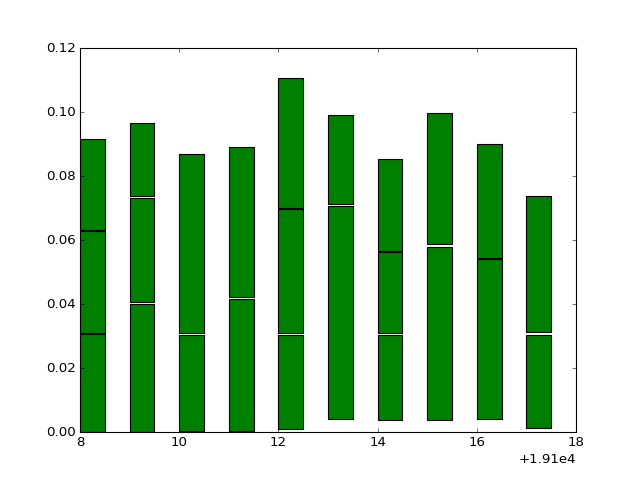

In [14]:
%matplotlib notebook
from __future__ import print_function # ensures compatibility on python 2.x
import subprocess, glob, os, time
import concurrent.futures
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

def show_timings(timings):
    t=np.array(timings)
    start_time=np.min(t[:,1])
    for i in range(t.shape[0]):
            p=plt.bar([int(t[i,0])], [t[i,2]-t[i,1]],0.5,color='g',bottom=[t[i,1]-start_time])
    plt.show()
    
def do_python(fn):
    c=None
    a = np.random.randn(6*7*8*9).reshape((6,7,8,9))
    b = np.random.randn(6*7*8*9)[::-1].reshape((8,7,9,6))
    c=np.dot(a,b)
    if c is not None:
        return "do_python: %f"%(c.flatten().sum())
    else:
        return "do_python: %s"%(fn)

def process_file(fn):
    # a three-step (serial) pipeline involving two subprocess calls.
    start=time.time()
    s=[]
    sp1 = subprocess.Popen(["file",fn],stdout=subprocess.PIPE)  # first step: subprocess returning filetype info
    sp1.wait()
    s.append("sp1: %s"%(sp1.stdout.read()))
    s.append(do_python(fn))                                     # second step: (dummy) python function
    sp2 = subprocess.Popen(["wc", fn],stdout=subprocess.PIPE)   # third step: subprocess returning # of lines/words/chars
    sp2.wait()
    s.append("sp2: %s"%(sp2.stdout.read()))
    finished=time.time()
    return ("\n".join(s), os.getpid(), start, finished)

def main():
    n_proc=10
    all_files=glob.glob(os.path.expanduser("./*"))
    start=time.time()
    # with concurrent.futures.ProcessPoolExecutor(max_workers=n_proc) as executor:    ## these two lines do the same as the line 
    #   results=executor.map(process_file,all_files)               ## below but use the concurrent.futures interface
    #with concurrent.futures.ThreadPoolExecutor(max_workers=n_proc) as executor:    ## these two lines do the same as the line 
    #   results=executor.map(process_file,all_files)               ## below but use the concurrent.futures interface
    p = mp.Pool(n_proc)
    results=p.map(process_file,all_files)
    total_time=(time.time()-start)*1000
    timings=[]
    for x in results:
        print(x[0])
        timings.append(x[1:])
    print("# of processes: %d   # of files processed: %d"%(n_proc,len(all_files)))
    print("wall time: %7.3f ms"%(total_time))
    sum_pchildren=sum([(x[2]-x[1]) for x in timings])*1000
    print("cumulated time of child processes: %7.3f ms"%sum_pchildren)
    print("efficiency= %7.3f/(%d*%7.3f)=%7.3f"%(sum_pchildren, n_proc,total_time, sum_pchildren/(n_proc*total_time)))
    print("avg. duration of a child process: %7.3f ms"%(sum_pchildren/len(all_files)))
    show_timings(timings)

if __name__=="__main__":  # Note: use of multiprocessing always needs to be encapsulated by __name__=="__main__"
    main()
    


**Exercises: **

a) Run the above pipeline with different numbers of processes. Observe the effect on efficiency and the avg time needed for a file. Which number of processes result in the shortest wall time? What did you expect? 

b) Uncomment the last line of main() to get a chart of the process timings. How much time does it take until a process is started or restarted? What does that imply for the task granularity that is suited for multiprocessing?

c) multiprocessing.dummy provides the multiprocessing API on top of the threading module. Use multiprocessing.dummy instead of multiprocessing. Compare and explain the observed timings.

d) the modern concurrent.future interface can be used with either thread pools or process pools. Uncomment each of the two respective lines (after commenting the two lines of the multiprocessing pool below). Any differences?